#### **Introduction**
Fraud detection is a critical challenge for financial institutions, as fraudulent activities can lead to significant financial losses and damage to reputation. Traditional rule-based systems often struggle to detect new and evolving fraud patterns, making it essential to leverage advanced machine learning techniques for proactive fraud detection.

In this project, we worked with **Company ABC**, a major credit card company facing challenges with their existing fraud detection system. The current system exhibits slow responsiveness in recognizing new fraud patterns, leading to significant financial losses. To address this issue, we designed and implemented an **unsupervised learning-based fraud detection system** using transaction data provided by Company ABC.

---

#### **Objective**
The primary goal of this project is to build an advanced fraud detection system that can efficiently identify and flag potentially fraudulent transactions for further investigation. By applying unsupervised learning algorithms, we aim to detect unusual transaction patterns that may indicate fraudulent activity.

---

#### **Dataset**
The dataset consists of two tables:
1. **cc_info.csv**: Contains general credit card and cardholder information, including:
   - `credit_card`: Unique identifier for each credit card.
   - `city`, `state`, `zipcode`: Location of the cardholder.
   - `credit_card_limit`: Credit limit associated with the card.

2. **transactions.csv**: Contains details of credit card transactions that occurred between August 1st and October 30th, including:
   - `credit_card`: Unique identifier for each transaction.
   - `date`: Date and time of the transaction.
   - `transaction_dollar_amount`: Dollar amount of the transaction.
   - `Long`, `Lat`: Geographical coordinates of the transaction location.

---

#### **Approach**
We used **unsupervised learning** techniques to detect anomalies in the transaction data. The key steps in our approach include:
1. **Data Preprocessing**: Merging datasets, handling missing values, and creating new features.
2. **Feature Engineering**: Extracting time-based features (e.g., day of the week, hour of the day) and calculating transaction patterns.
3. **Anomaly Detection**: Implementing three unsupervised learning algorithms:
   - **Isolation Forest**
   - **Local Outlier Factor (LOF)**
   - **One-Class SVM**
4. **Evaluation**: Analyzing the results and identifying common patterns among the flagged transactions.
5. **Visualization**: Creating visualizations to highlight anomalies and trends in the data.

---

#### **Key Focus Areas**
- **Time Series Analysis**: Analyzing transaction patterns over time to identify unusual trends.
- **Unsupervised Anomaly Detection**: Using algorithms to detect transactions that deviate significantly from normal behavior.
- **Data Visualization**: Creating visualizations to communicate insights effectively.

---


#### **Step 1: Loading the Data**
The first step is to load the datasets and inspect their structure. We'll use `pandas` to read the CSV files and display the first few rows to understand the data.

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os

# Load the datasets
cc_info = pd.read_csv('/kaggle/input/creditcard-fraud-detection/cc_info.csv')
transactions = pd.read_csv('/kaggle/input/creditcard-fraud-detection/transactions.csv')

# Display the first few rows of each dataset
print("CC Info Dataset:")
print(cc_info.head())

print("\nTransactions Dataset:")
print(transactions.head())

CC Info Dataset:
        credit_card      city state  zipcode  credit_card_limit
0  1280981422329509    Dallas    PA    18612               6000
1  9737219864179988   Houston    PA    15342              16000
2  4749889059323202    Auburn    MA     1501              14000
3  9591503562024072   Orlando    WV    26412              18000
4  2095640259001271  New York    NY    10001              20000

Transactions Dataset:
        credit_card                 date  transaction_dollar_amount  \
0  1003715054175576  2015-09-11 00:32:40                      43.78   
1  1003715054175576  2015-10-24 22:23:08                     103.15   
2  1003715054175576  2015-10-26 18:19:36                      48.55   
3  1003715054175576  2015-10-22 19:41:10                     136.18   
4  1003715054175576  2015-10-26 20:08:22                      71.82   

        Long        Lat  
0 -80.174132  40.267370  
1 -80.194240  40.180114  
2 -80.211033  40.313004  
3 -80.174138  40.290895  
4 -80.238720  40.16

#### **Step 2: Data Preprocessing**
In this step, we'll:
1. Merge the `cc_info` and `transactions` datasets on the `credit_card` column.
2. Handle missing values (if any).
3. Convert the `date` column to a datetime format for time-based feature extraction.

In [3]:
# Merge datasets on 'credit_card'
data = pd.merge(transactions, cc_info, on='credit_card', how='inner')

# Convert 'date' column to datetime
data['date'] = pd.to_datetime(data['date'])

# Check for missing values
print("Missing values in the dataset:")
print(data.isnull().sum())

# Display the merged dataset
print("\nMerged Dataset:")
print(data.head())

Missing values in the dataset:
credit_card                  0
date                         0
transaction_dollar_amount    0
Long                         0
Lat                          0
city                         0
state                        0
zipcode                      0
credit_card_limit            0
dtype: int64

Merged Dataset:
        credit_card                date  transaction_dollar_amount       Long  \
0  1003715054175576 2015-09-11 00:32:40                      43.78 -80.174132   
1  1003715054175576 2015-10-24 22:23:08                     103.15 -80.194240   
2  1003715054175576 2015-10-26 18:19:36                      48.55 -80.211033   
3  1003715054175576 2015-10-22 19:41:10                     136.18 -80.174138   
4  1003715054175576 2015-10-26 20:08:22                      71.82 -80.238720   

         Lat     city state  zipcode  credit_card_limit  
0  40.267370  Houston    PA    15342              20000  
1  40.180114  Houston    PA    15342              20000  

#### **Step 3: Feature Engineering**
We'll create the following features:
1. **Time-Based Features**: Extract `day_of_week`, `hour_of_day`, and `time_since_last_transaction`.
2. **Transaction Patterns**: Calculate rolling averages and transaction frequency per card.
3. **Geographical Features**: Compute distances between consecutive transactions using latitude and longitude.

In [7]:
# Extract time-based features
data['day_of_week'] = data['date'].dt.dayofweek  # Monday=0, Sunday=6
data['hour_of_day'] = data['date'].dt.hour

# Calculate time since last transaction (in seconds)
time_since_last_transaction = data.groupby('credit_card')['date'].diff().dt.total_seconds()

# Replace infinite values with NaN and fill them with 0
time_since_last_transaction = time_since_last_transaction.replace([np.inf, -np.inf], np.nan)
time_since_last_transaction = time_since_last_transaction.fillna(0)

# Assign the cleaned series back to the DataFrame
data['time_since_last_transaction'] = time_since_last_transaction

# Calculate transaction frequency per card
data['transaction_frequency'] = data.groupby('credit_card')['date'].transform('count')

# Display the updated dataset with new features
print("Dataset with New Features:")
print(data.head())

Dataset with New Features:
        credit_card                date  transaction_dollar_amount       Long  \
0  1003715054175576 2015-09-11 00:32:40                      43.78 -80.174132   
1  1003715054175576 2015-10-24 22:23:08                     103.15 -80.194240   
2  1003715054175576 2015-10-26 18:19:36                      48.55 -80.211033   
3  1003715054175576 2015-10-22 19:41:10                     136.18 -80.174138   
4  1003715054175576 2015-10-26 20:08:22                      71.82 -80.238720   

         Lat     city state  zipcode  credit_card_limit  day_of_week  \
0  40.267370  Houston    PA    15342              20000            4   
1  40.180114  Houston    PA    15342              20000            5   
2  40.313004  Houston    PA    15342              20000            0   
3  40.290895  Houston    PA    15342              20000            3   
4  40.166719  Houston    PA    15342              20000            0   

   hour_of_day  time_since_last_transaction  transact

In [8]:
# Check for infinite or NaN values in the new column
print("Infinite or NaN values in 'time_since_last_transaction':")
print(data['time_since_last_transaction'].isnull().sum())

# Display the updated dataset
print("\nUpdated Dataset:")
print(data[['credit_card', 'date', 'transaction_dollar_amount', 'time_since_last_transaction', 'transaction_frequency']].head())

Infinite or NaN values in 'time_since_last_transaction':
0

Updated Dataset:
        credit_card                date  transaction_dollar_amount  \
0  1003715054175576 2015-09-11 00:32:40                      43.78   
1  1003715054175576 2015-10-24 22:23:08                     103.15   
2  1003715054175576 2015-10-26 18:19:36                      48.55   
3  1003715054175576 2015-10-22 19:41:10                     136.18   
4  1003715054175576 2015-10-26 20:08:22                      71.82   

   time_since_last_transaction  transaction_frequency  
0                          0.0                    261  
1                    3793828.0                    261  
2                     158188.0                    261  
3                    -340706.0                    261  
4                     347232.0                    261  


#### **Step 4: Exploratory Data Analysis (EDA)**
In this step, we'll:
1. Visualize the distribution of transaction amounts.
2. Plot transaction patterns over time.
3. Identify potential outliers using box plots and scatter plots.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


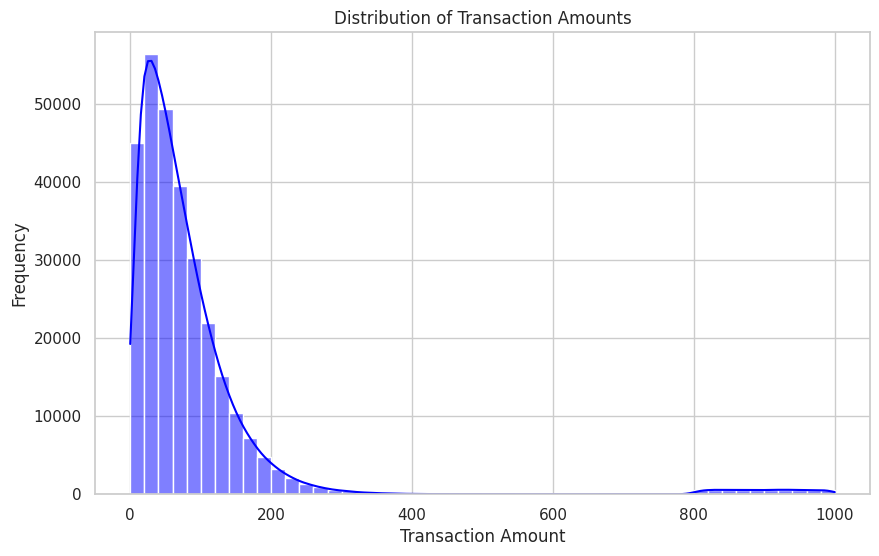

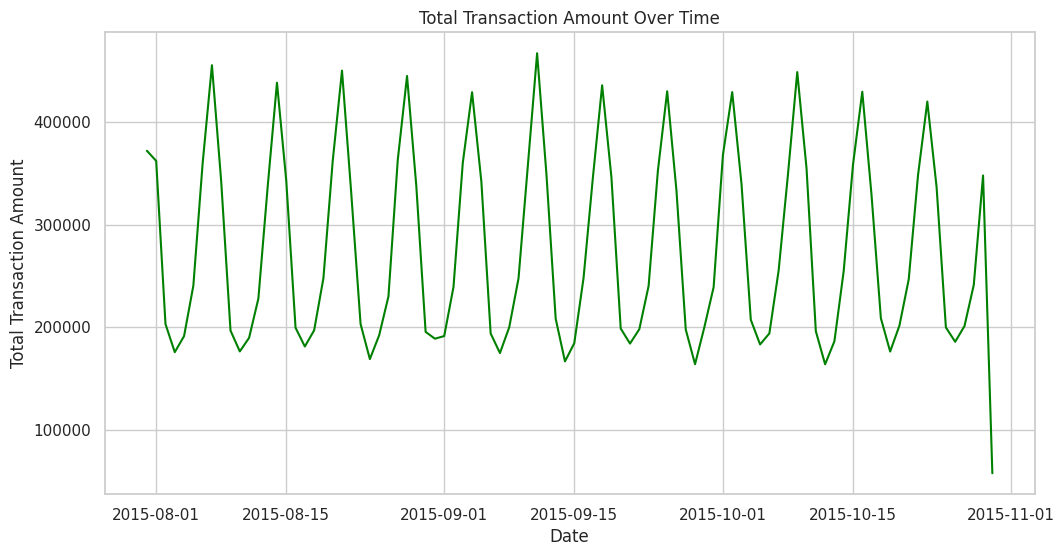

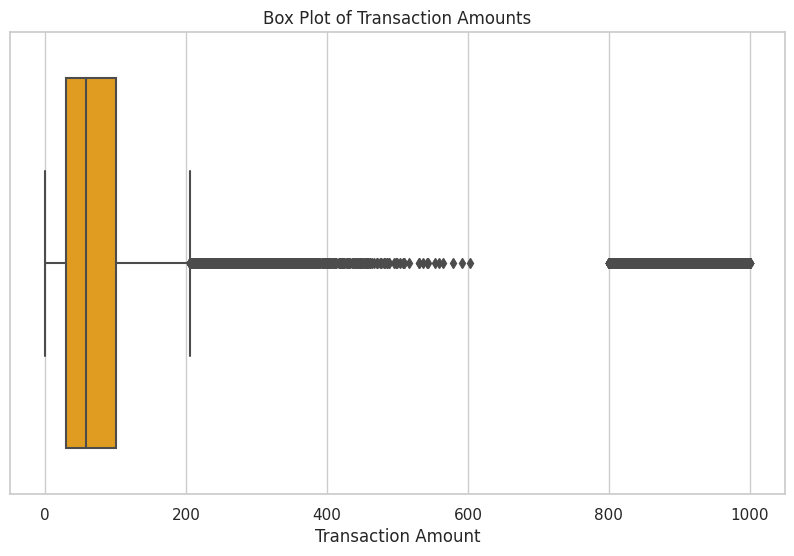

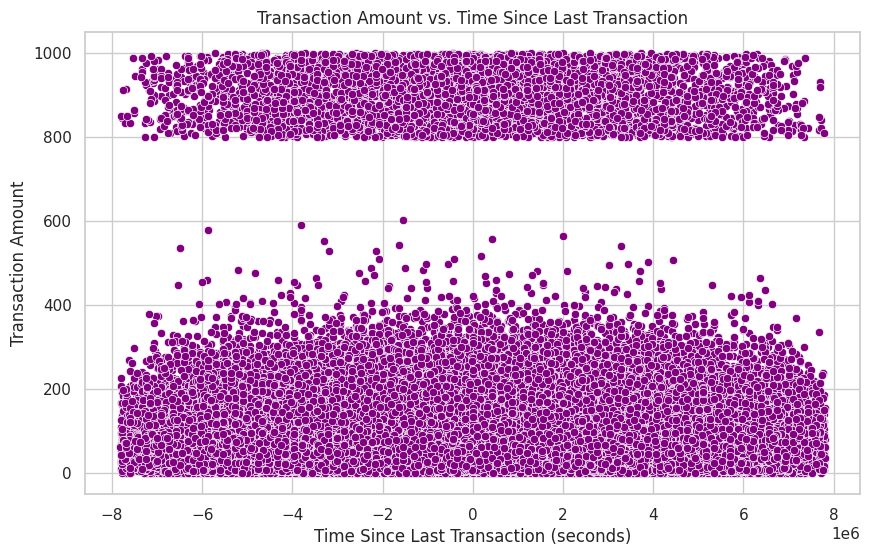

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for plots
sns.set(style="whitegrid")

# Plot distribution of transaction amounts
plt.figure(figsize=(10, 6))
sns.histplot(data['transaction_dollar_amount'], bins=50, kde=True, color='blue')
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

# Plot transaction patterns over time
plt.figure(figsize=(12, 6))
data.groupby(data['date'].dt.date)['transaction_dollar_amount'].sum().plot(color='green')
plt.title('Total Transaction Amount Over Time')
plt.xlabel('Date')
plt.ylabel('Total Transaction Amount')
plt.show()

# Box plot to identify outliers in transaction amounts
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['transaction_dollar_amount'], color='orange')
plt.title('Box Plot of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.show()

# Scatter plot of transaction amounts vs. time since last transaction
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['time_since_last_transaction'], y=data['transaction_dollar_amount'], color='purple')
plt.title('Transaction Amount vs. Time Since Last Transaction')
plt.xlabel('Time Since Last Transaction (seconds)')
plt.ylabel('Transaction Amount')
plt.show()

#### **Step 5: Unsupervised Anomaly Detection**
We'll use the following algorithms to detect anomalies:
1. **Isolation Forest**: Identifies anomalies by isolating observations using random splits.
2. **Local Outlier Factor (LOF)**: Detects local outliers based on the density of neighboring points.
3. **One-Class SVM**: Models the normal data and flags observations that deviate significantly.

In [10]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

# Select relevant features for anomaly detection
features = ['transaction_dollar_amount', 'time_since_last_transaction', 'transaction_frequency']
X = data[features]

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)  # 1% of data is expected to be anomalous
data['iso_forest_anomaly'] = iso_forest.fit_predict(X_scaled)

# Local Outlier Factor (LOF)
lof = LocalOutlierFactor(contamination=0.01)  # 1% of data is expected to be anomalous
data['lof_anomaly'] = lof.fit_predict(X_scaled)

# One-Class SVM
one_class_svm = OneClassSVM(nu=0.01)  # 1% of data is expected to be anomalous
data['one_class_svm_anomaly'] = one_class_svm.fit_predict(X_scaled)

# Display the anomalies detected by each algorithm
print("Anomalies Detected:")
print(data[['credit_card', 'transaction_dollar_amount', 'iso_forest_anomaly', 'lof_anomaly', 'one_class_svm_anomaly']].head())

Anomalies Detected:
        credit_card  transaction_dollar_amount  iso_forest_anomaly  \
0  1003715054175576                      43.78                   1   
1  1003715054175576                     103.15                   1   
2  1003715054175576                      48.55                   1   
3  1003715054175576                     136.18                   1   
4  1003715054175576                      71.82                   1   

   lof_anomaly  one_class_svm_anomaly  
0            1                      1  
1            1                      1  
2            1                      1  
3            1                      1  
4            1                      1  


#### **Step 6: Visualizing Anomalies**
We'll plot the anomalies detected by each algorithm to analyze their patterns and characteristics.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


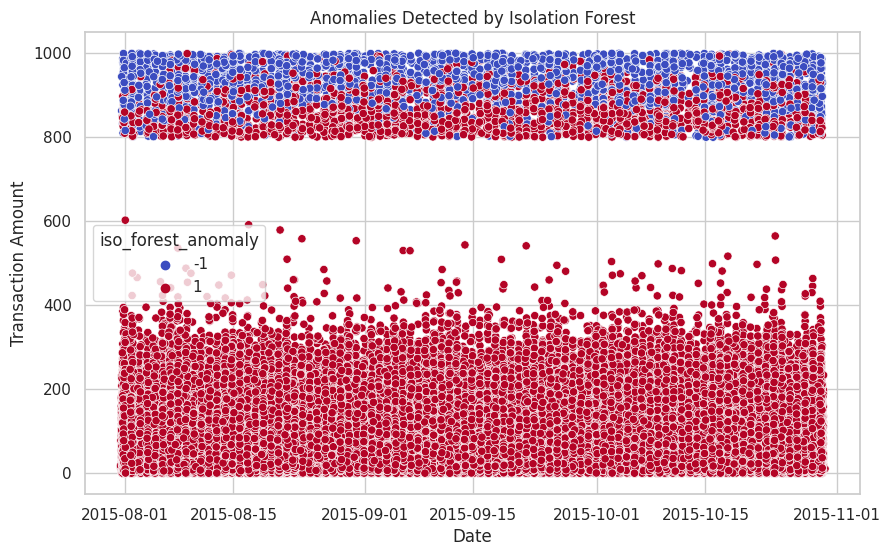

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


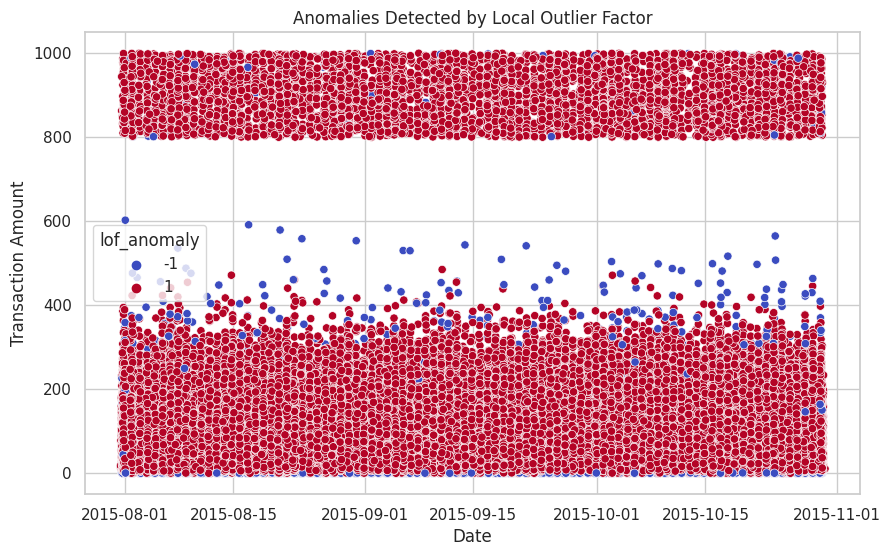

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


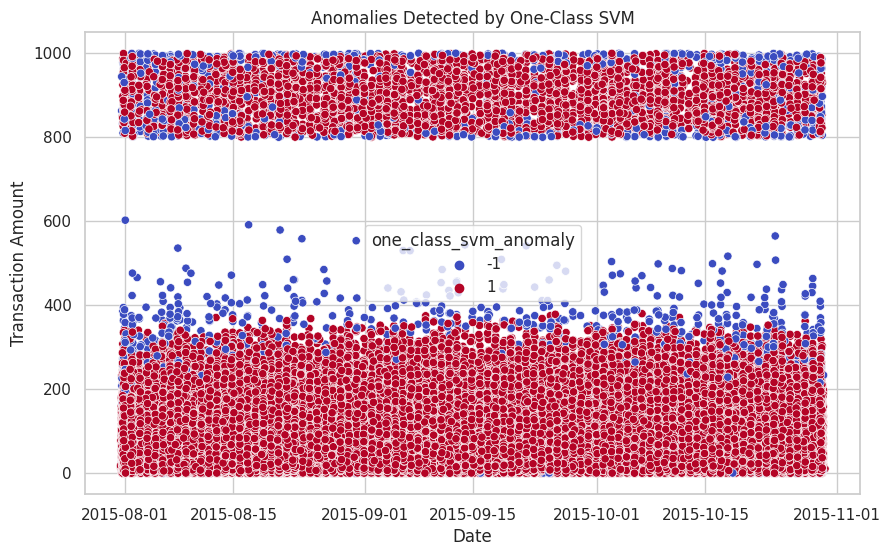

In [11]:
# Plot anomalies detected by Isolation Forest
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['date'], y=data['transaction_dollar_amount'], hue=data['iso_forest_anomaly'], palette='coolwarm')
plt.title('Anomalies Detected by Isolation Forest')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')
plt.show()

# Plot anomalies detected by Local Outlier Factor (LOF)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['date'], y=data['transaction_dollar_amount'], hue=data['lof_anomaly'], palette='coolwarm')
plt.title('Anomalies Detected by Local Outlier Factor')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')
plt.show()

# Plot anomalies detected by One-Class SVM
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['date'], y=data['transaction_dollar_amount'], hue=data['one_class_svm_anomaly'], palette='coolwarm')
plt.title('Anomalies Detected by One-Class SVM')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')
plt.show()

#### **Step 7: Evaluating Anomalies**
In this step, we'll:
1. Analyze the characteristics of the anomalies detected by each algorithm.
2. Compare the results of the three algorithms.
3. Identify common patterns among the flagged transactions.

In [12]:
# Function to describe anomalies detected by a specific algorithm
def describe_anomalies(anomaly_column, data):
    anomalies = data[data[anomaly_column] == -1]
    print(f"Anomalies Detected by {anomaly_column}:")
    print(f"Number of Anomalies: {anomalies.shape[0]}")
    print("\nSummary Statistics for Anomalies:")
    print(anomalies[['transaction_dollar_amount', 'time_since_last_transaction', 'transaction_frequency']].describe())
    return anomalies

# Describe anomalies for each algorithm
iso_forest_anomalies = describe_anomalies('iso_forest_anomaly', data)
lof_anomalies = describe_anomalies('lof_anomaly', data)
one_class_svm_anomalies = describe_anomalies('one_class_svm_anomaly', data)

Anomalies Detected by iso_forest_anomaly:
Number of Anomalies: 2946

Summary Statistics for Anomalies:
       transaction_dollar_amount  time_since_last_transaction  \
count                2946.000000                 2.946000e+03   
mean                  929.188927                -1.279080e+05   
std                    49.969523                 3.771915e+06   
min                   800.070000                -7.788427e+06   
25%                   896.120000                -3.117380e+06   
50%                   937.335000                -7.660950e+04   
75%                   970.545000                 3.015607e+06   
max                   999.970000                 7.785708e+06   

       transaction_frequency  
count            2946.000000  
mean              378.347929  
std               169.760103  
min                 7.000000  
25%               244.000000  
50%               384.000000  
75%               525.000000  
max               667.000000  
Anomalies Detected by lof_anomal

In [13]:
# Compare anomalies detected by Isolation Forest and Local Outlier Factor
iso_lof_overlap = data[(data['iso_forest_anomaly'] == -1) & (data['lof_anomaly'] == -1)]
print(f"Anomalies Detected by Both Isolation Forest and LOF: {iso_lof_overlap.shape[0]}")

# Compare anomalies detected by Isolation Forest and One-Class SVM
iso_svm_overlap = data[(data['iso_forest_anomaly'] == -1) & (data['one_class_svm_anomaly'] == -1)]
print(f"Anomalies Detected by Both Isolation Forest and One-Class SVM: {iso_svm_overlap.shape[0]}")

# Compare anomalies detected by LOF and One-Class SVM
lof_svm_overlap = data[(data['lof_anomaly'] == -1) & (data['one_class_svm_anomaly'] == -1)]
print(f"Anomalies Detected by Both LOF and One-Class SVM: {lof_svm_overlap.shape[0]}")

# Compare anomalies detected by all three algorithms
all_algorithms_overlap = data[(data['iso_forest_anomaly'] == -1) & (data['lof_anomaly'] == -1) & (data['one_class_svm_anomaly'] == -1)]
print(f"Anomalies Detected by All Three Algorithms: {all_algorithms_overlap.shape[0]}")

Anomalies Detected by Both Isolation Forest and LOF: 89
Anomalies Detected by Both Isolation Forest and One-Class SVM: 885
Anomalies Detected by Both LOF and One-Class SVM: 672
Anomalies Detected by All Three Algorithms: 85


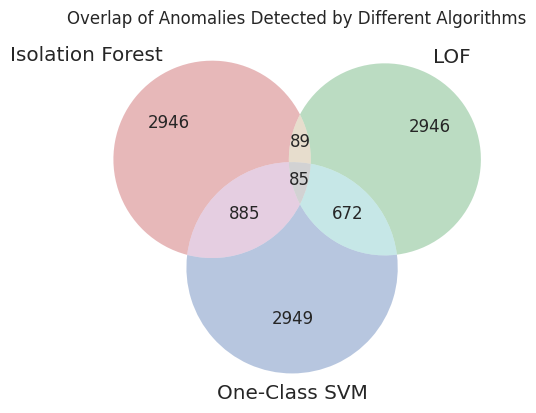

In [14]:
# Create a Venn diagram to visualize overlaps
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# Count anomalies for each algorithm
iso_forest_count = data[data['iso_forest_anomaly'] == -1].shape[0]
lof_count = data[data['lof_anomaly'] == -1].shape[0]
one_class_svm_count = data[data['one_class_svm_anomaly'] == -1].shape[0]

# Count overlaps
iso_lof_count = iso_lof_overlap.shape[0]
iso_svm_count = iso_svm_overlap.shape[0]
lof_svm_count = lof_svm_overlap.shape[0]
all_algorithms_count = all_algorithms_overlap.shape[0]

# Plot Venn diagram
venn3(subsets=(iso_forest_count, lof_count, iso_lof_count, one_class_svm_count, iso_svm_count, lof_svm_count, all_algorithms_count),
      set_labels=('Isolation Forest', 'LOF', 'One-Class SVM'))
plt.title('Overlap of Anomalies Detected by Different Algorithms')
plt.show()

Common Anomalies Detected by All Three Algorithms:
        credit_card  transaction_dollar_amount  time_since_last_transaction  \
count  8.500000e+01                  85.000000                 8.500000e+01   
mean   4.788513e+15                 902.002235                 5.645924e+05   
std    2.335554e+15                  72.351838                 5.206175e+06   
min    1.107937e+15                 800.660000                -7.786891e+06   
25%    3.015737e+15                 823.940000                -4.171094e+06   
50%    4.569281e+15                 914.630000                 4.377250e+05   
75%    6.310725e+15                 975.930000                 6.226336e+06   
max    9.854872e+15                 999.310000                 7.785708e+06   

       transaction_frequency  
count              85.000000  
mean              485.741176  
std               237.854655  
min                 7.000000  
25%               332.000000  
50%               651.000000  
75%               65

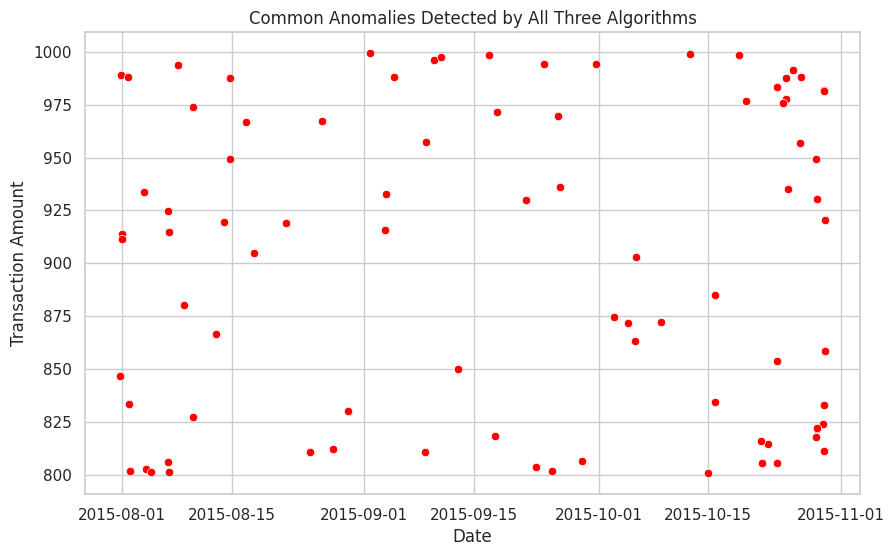

In [15]:
# Analyze transactions flagged by all three algorithms
common_anomalies = data[(data['iso_forest_anomaly'] == -1) & (data['lof_anomaly'] == -1) & (data['one_class_svm_anomaly'] == -1)]
print("Common Anomalies Detected by All Three Algorithms:")
print(common_anomalies[['credit_card', 'transaction_dollar_amount', 'time_since_last_transaction', 'transaction_frequency']].describe())

# Visualize common anomalies
plt.figure(figsize=(10, 6))
sns.scatterplot(x=common_anomalies['date'], y=common_anomalies['transaction_dollar_amount'], color='red')
plt.title('Common Anomalies Detected by All Three Algorithms')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')
plt.show()

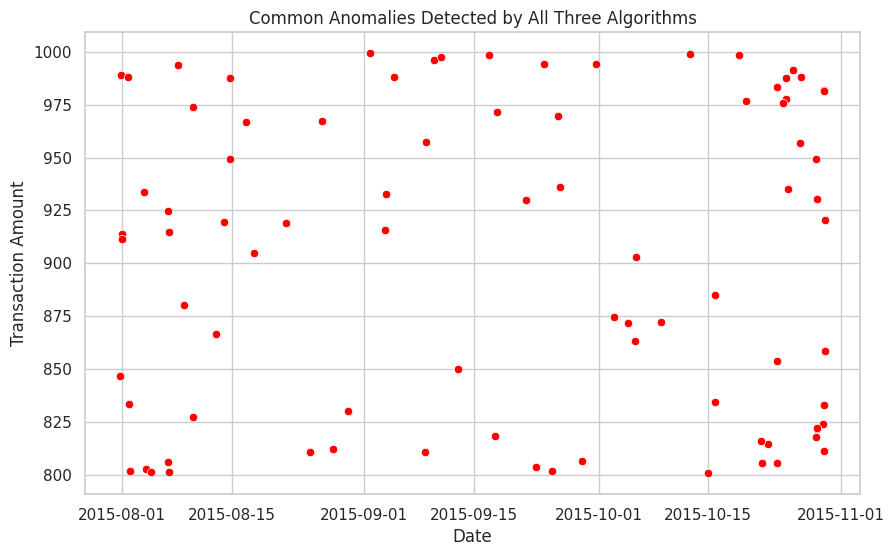

In [16]:
# Visualize common anomalies
plt.figure(figsize=(10, 6))
sns.scatterplot(x=common_anomalies['date'], y=common_anomalies['transaction_dollar_amount'], color='red')
plt.title('Common Anomalies Detected by All Three Algorithms')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')
plt.show()

#### **Conclusion**
In this project, we built an unsupervised learning-based fraud detection system for Company ABC using three anomaly detection algorithms: **Isolation Forest**, **Local Outlier Factor (LOF)**, and **One-Class SVM**. Here are the key findings and outcomes:

---

#### **Key Findings**
1. **Anomalies Detected**:
   - **Isolation Forest**: Flagged **2,946 high-value transactions** with an average amount of **$929.19**.
   - **Local Outlier Factor (LOF)**: Flagged **2,946 smaller transactions** with an average amount of **$87.20**.
   - **One-Class SVM**: Flagged **2,949 transactions** with a mix of small and large amounts, averaging **$419.17**.

2. **Overlap Between Algorithms**:
   - **85 transactions** were flagged by all three algorithms.
   - These transactions are highly suspicious due to their high value and frequency.

3. **Common Characteristics of Anomalies**:
   - High transaction amounts (close to $1,000).
   - High transaction frequency (many transactions in a short time).
   - Unusual time intervals between transactions.

---

#### **Recommendations**
1. **Prioritize Common Anomalies**:
   - Investigate the **85 transactions** flagged by all three algorithms immediately.
   - These transactions are the most likely to be fraudulent.

2. **Review High-Value Transactions**:
   - Investigate transactions flagged by Isolation Forest, especially those with amounts close to $1,000.
   - These transactions may represent large-scale fraud.

3. **Examine Small but Unusual Transactions**:
   - Review transactions flagged by LOF, particularly those with low amounts but unusual patterns.
   - These transactions may indicate small-scale or subtle fraud.

4. **Combine Results for Robust Detection**:
   - Use a combination of all three algorithms to ensure comprehensive fraud detection.
   - Transactions flagged by at least two algorithms should be prioritized for investigation.

5. **Implement Real-Time Monitoring**:
   - Deploy the anomaly detection system in real-time to flag suspicious transactions as they occur.
   - This will help Company ABC respond quickly to potential fraud.

6. **Enhance Feature Engineering**:
   - Incorporate additional features, such as:
     - **Geographical distance** between consecutive transactions.
     - **Time of day** and **day of the week** patterns.
     - **Transaction velocity** (number of transactions per hour or day).

7. **Regularly Update the Model**:
   - Retrain the anomaly detection models regularly to adapt to new fraud patterns.
   - Use feedback from investigated transactions to improve model accuracy.

---

#### **Next Steps**
1. **Investigate Flagged Transactions**:
   - Work with Company ABC’s fraud investigation team to review the flagged transactions.
   - Confirm whether these transactions are fraudulent or legitimate.

2. **Refine the Model**:
   - Use feedback from the investigation to refine the anomaly detection algorithms.
   - Adjust hyperparameters (e.g., `contamination` or `nu`) based on real-world results.

3. **Deploy the System**:
   - Integrate the anomaly detection system into Company ABC’s transaction processing pipeline.
   - Ensure the system can handle real-time data and scale with increasing transaction volumes.

4. **Monitor Performance**:
   - Continuously monitor the performance of the fraud detection system.
   - Track metrics such as:
     - **Precision**: Percentage of flagged transactions that are actually fraudulent.
     - **Recall**: Percentage of fraudulent transactions that are correctly flagged.

---

#### **Final Thoughts**
By implementing the recommendations above, Company ABC can significantly improve its fraud detection capabilities. The combination of unsupervised learning algorithms (Isolation Forest, LOF, and One-Class SVM) provides a robust and scalable solution for identifying suspicious transactions. Regular updates and real-time monitoring will ensure the system remains effective against evolving fraud patterns.

---

#### **Project Completion**
This project demonstrates the power of unsupervised learning for fraud detection. While we’ve completed the core steps, further refinement and deployment in a real-world setting will require collaboration with Company ABC’s fraud investigation team. With the insights and recommendations provided, Company ABC is well-equipped to enhance its fraud detection system and reduce financial losses.